# TVA

In [1]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np 
import pandas as pd

In [2]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [3]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


(7, 200)
None


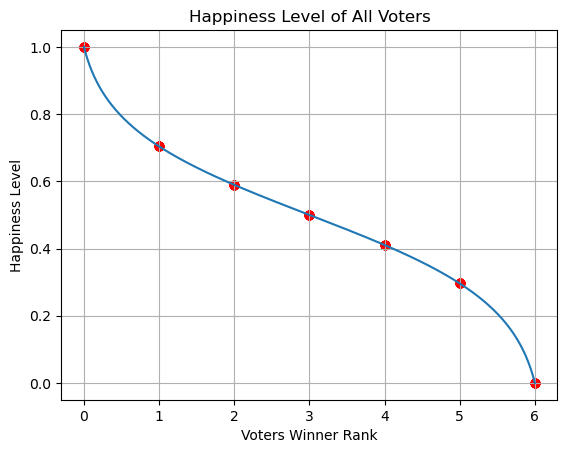

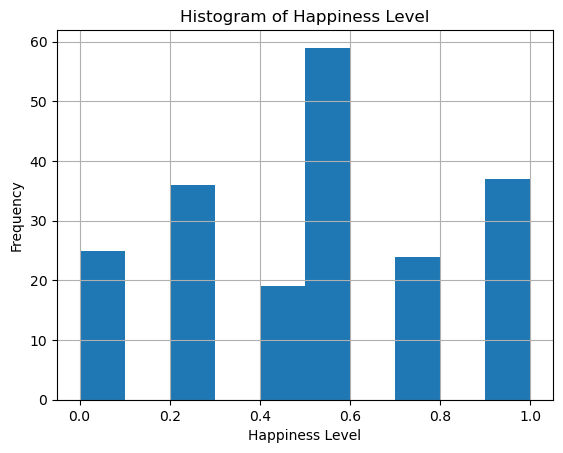

In [4]:
n_cand = 7
random_voting = utils.random_voting(200, n_cand)
print(random_voting.shape)
result_random = plurality_outcome(random_voting)
hlevel = HappinessLevel(random_voting, result_random.winner)
print(hlevel._all_happiness_level)
hlevel.plot()
hlevel.histogram()

## Strategic Voting

In [5]:
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


In [6]:
result = plurality_outcome(voting)
result

Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [7]:
happiness_level = HappinessLevel(voting, result.winner)
strategic_voting = StrategicVoting(voting).run(happiness_level, plurality_outcome)

strategic_voting.all

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487
1,5,"[B, D, A, C]",B,0.410487,0.0,2.820973,3.410487


The table displays the best strategic voting for each voter

In [8]:
strategic_voting.best

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487


Strategic Voting Risk

In [9]:
strategic_voting.risk

0.13682886358890622

# ADVANCED TVA 
Coalition, ideas

What i implemented can be explain in few steps:
- we divide people with their level of happiness; people that are really unhappy with the winner will be grouped togheter, etcetera
- once we find the coalitions, we find a manipulation that will garantee an increase of happiness for all the people of the coalition, in order to prove tha stability of the coalition.  Even a manipulation strategy will be implemented, the burying. 


Keep in mind that this doesn't work for plurality voting.

In [10]:

#Creation of some structures

voting_df= pd.DataFrame(random_voting).T
voting_df['H']= hlevel._all_happiness_level

# Divide people with their level of happiness
voting_df['gruppo'] = pd.qcut(voting_df['H'], 4, labels=False) 


coalitions = {}
for cluster_id, cluster_data in voting_df.groupby('gruppo'): 
    cluster_data = cluster_data.drop(['gruppo'], axis=1)
    rankings = np.array(cluster_data.drop(['H'], axis=1).T)
    coalitions[cluster_id] = (int(len(cluster_data)))
print(coalitions)
bigg_coal = max(coalitions, key=lambda k: coalitions[k])
print("Biggest Coalition:", bigg_coal)


{0: 61, 1: 51, 2: 51, 3: 37}
Biggest Coalition: 0


In [11]:
from itertools import permutations
from itertools import combinations
from itertools import product

def find_new_happiness(manipulations, coalition, voting_df): #Function that for a manipulation of a coalition gives you the new happiness values

    coalition['manipulation']=manipulations
    indici = coalition.index
    df = pd.DataFrame(manipulations, index= indici, columns=[i for i in range(0, n_cand)])
    new_voting_df = voting_df.copy()
    new_voting_df.loc[indici] = df
    new_results = plurality_outcome(new_voting_df.iloc[:, :n_cand].values.T)





    diz = HappinessLevel(voting_df.iloc[:, :n_cand].values.T, new_results.winner).happiness_level_dict 
    New_Happiness_Levels = pd.DataFrame.from_dict(diz, orient='index', columns=['New_H']) #compute the happiness of the new results with respect of the real preferences
    coalition = pd.merge(coalition, New_Happiness_Levels,left_index=True, right_index=True)
    return coalition, new_results

def analyze_core(coalition): #Analize if inside or not the code
    

    real_happ = coalition['H']
    fake_happ = coalition['New_H']
    
    comparison_result = [fake > real for real, fake in zip(real_happ, fake_happ)]
    
    if all(comparison_result):
        return True
    else:
        false_indices = [i for i, results in enumerate(comparison_result) if not results]
        return False
 

'''
perm=[]

for index, row in coalition.drop(['H', 'gruppo'], axis=1).iterrows():
    perm.append(list(permutations(list(row.iloc[0:7]))))


primi_elementi = [sotto_lista[3] for sotto_lista in perm]
coalition['manipulation']=primi_elementi
coalition = find_new_happiness(primi_elementi, coalition, voting_df)
print(analyze_core(coalition))'''


"\nperm=[]\n\nfor index, row in coalition.drop(['H', 'gruppo'], axis=1).iterrows():\n    perm.append(list(permutations(list(row.iloc[0:7]))))\n\n\nprimi_elementi = [sotto_lista[3] for sotto_lista in perm]\ncoalition['manipulation']=primi_elementi\ncoalition = find_new_happiness(primi_elementi, coalition, voting_df)\nprint(analyze_core(coalition))"

In [12]:
#Burying

win = result_random.winner

print('true result:  ', result_random)
for coal_id, coalition in voting_df.groupby('gruppo'):

    man=[]
    
    for index, row in coalition.iterrows():
        pref = list(row.iloc[0:-2])
        ind = pref.index(win)
        #print(ind, row['H'])
        pref.pop(ind)
        pref.append(win)
        man.append(pref)
    coal_new_h, new_result = find_new_happiness(man, coalition, voting_df)
    print(new_result)
    analyze_core(coal_new_h)
    if analyze_core(coal_new_h) == True:
        print(f'Burying made everyone in the group {coal_id} happier, here the new winner:  ', new_result)


    
    

true result:   Winner: A
{'A': 37, 'B': 26, 'C': 31, 'D': 27, 'E': 22, 'F': 22, 'G': 35}
Winner: A
{'A': 37, 'B': 26, 'C': 31, 'D': 27, 'E': 22, 'F': 22, 'G': 35}
Winner: A
{'A': 37, 'B': 26, 'C': 31, 'D': 27, 'E': 22, 'F': 22, 'G': 35}
Winner: A
{'A': 37, 'B': 26, 'C': 31, 'D': 27, 'E': 22, 'F': 22, 'G': 35}
Winner: G
{'A': 0, 'B': 33, 'C': 36, 'D': 32, 'E': 26, 'F': 28, 'G': 45}


We can try to push down people different than the winner for seing if the happiness is gonna increase

In [15]:
voting_df= pd.DataFrame(random_voting).T
voting_df['H']= hlevel._all_happiness_level

# Divide people with their level of happiness
voting_df['gruppo'] = pd.qcut(voting_df['H'], 4, labels=False) 


print('true result:  ', result_random)
winning_sorting = sorted(result_random.items(), key=lambda x: x[1], reverse=True)
winning_sorting = [item[0] for item in winning_sorting]

coalitions = {}

for cluster_id, cluster_data in voting_df.groupby('gruppo'): 
    cluster_data = cluster_data.drop(['gruppo'], axis=1)
    rankings = np.array(cluster_data.drop(['H'], axis=1).T)
    coalitions[cluster_id] = (int(len(cluster_data)))


for cand in winning_sorting[1:]:
    for coal_id, coalition in voting_df.groupby('gruppo'):
        if coal_id!=3:
            man=[]
            for index, row in coalition.iterrows():
                pref = list(row.iloc[0:-2])
                ind = pref.index(cand)
                #print(ind, row['H'])
                pref.pop(ind)
                pref.append(cand)
                man.append(pref)

            coal_new_h, new_result = find_new_happiness(man, coalition, voting_df)

            analyze_core(coal_new_h)
            if analyze_core(coal_new_h) == True:

                print(f'Burying {cand} made everyone in the group {coal_id} happier, here the new winner:  ', new_result)
                print(coal_new_h)
                break

            else:
                if new_result.winner!=result_random.winner:

                    print(new_result)
                    print(coal_new_h.iloc[0:1])

            

true result:   Winner: A
{'A': 37, 'B': 26, 'C': 31, 'D': 27, 'E': 22, 'F': 22, 'G': 35}
Winner: G
{'A': 37, 'B': 28, 'C': 19, 'D': 31, 'E': 25, 'F': 22, 'G': 38}
   0  1  2  3  4  5  6        H  gruppo           manipulation  New_H
1  D  E  F  B  C  A  G  0.29611       0  [D, E, F, B, A, G, C]    0.0
Winner: G
{'A': 37, 'B': 28, 'C': 33, 'D': 16, 'E': 25, 'F': 23, 'G': 38}
   0  1  2  3  4  5  6        H  gruppo           manipulation  New_H
1  D  E  F  B  C  A  G  0.29611       0  [E, F, B, C, A, G, D]    0.0
Winner: G
{'A': 37, 'B': 27, 'C': 32, 'D': 28, 'E': 13, 'F': 25, 'G': 38}
   0  1  2  3  4  5  6        H  gruppo           manipulation  New_H
1  D  E  F  B  C  A  G  0.29611       0  [D, F, B, C, A, G, E]    0.0


We could generate a metrics for the risk of burying with coalitions

# COMPROMISING
another strategy that a coalition could apply is the Compromising strategy. People, grouped with their level of happiness try to elect a best winner for them. 

In [34]:
#Find the candidates ranked in a higher position with respect of everyone in the coalition
def remove_elements_above_or_equal_index(lst, index):
    if index < 0 or index >= len(lst):
        return lst  # Se l'indice è fuori dai limiti, restituisci la lista non modificata
    
    return lst[:index]  # Restituisci gli elementi fino alla posizione precedente all'indice specificato
print(win)
for coal_id, coalition in voting_df.groupby('gruppo'):
    i=0
    man=[]
    elected = []
    for index, row in coalition.iterrows():
        pref = list(row.iloc[0:-2])
        ind = pref.index(win)
        #print(ind, row['H'])
        candidates = set(remove_elements_above_or_equal_index(pref, ind))
        man.append(candidates)
    i=0
    intersection = man[1]
    for el in man:
        intersection = set.intersection(el, intersection)
        print(f'preferenze:   {el}, intersezione:  {intersection}')
    
    









A
preferenze:   {'E', 'F', 'D', 'C', 'B'}, intersezione:  {'E', 'F', 'D', 'C', 'B'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezione:  {'E', 'F', 'D', 'C', 'B'}
preferenze:   {'F', 'D', 'C', 'G', 'B'}, intersezione:  {'D', 'B', 'C', 'F'}
preferenze:   {'E', 'F', 'D', 'G', 'B'}, intersezione:  {'D', 'B', 'F'}
preferenze:   {'E', 'F', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'F', 'D', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'C', 'G', 'B'}, intersezione:  {'B', 'F'}
preferenze:   {'E', 'F', 'D', 'C', 'G', 'B'}, intersezion